In [1]:
# imports
from pyha_analyzer import extractors

from buowset_extractor import buowset_extractor
from pyha_analyzer.preprocessors import MelSpectrogramPreprocessorsNew
import torch
from datetime import datetime


import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader


from torchvision.utils import make_grid

from tqdm.notebook import tqdm

import numpy as np

In [2]:
config = {
    "learning_rate": 10e-3,
    "learning_rate_decay": 0.001,
    "device": 'cuda',
    "latent_dim": 1024
}

In [3]:
# extract our data
buow_ads = buowset_extractor(metadata_csv="/home/a.jajodia.229/acoustic/local_data/buow/buowset/meta/metadata.csv",
                              parent_path="/home/a.jajodia.229/acoustic/local_data/buow/buowset/audio",
                              output_path="/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/autoencoding"
                              )



def encode(batch):
    raw_audio = []
    for item_idx in range(len(batch["audio"])):
        audio = batch['audio'][item_idx]['array'][0:32768]
        audio_padded = np.pad(audio, pad_width=(0, 32768-len(audio)), mode="edge")
    
        raw_audio.append(audio_padded)

    batch['audio'] = np.expand_dims(np.array(raw_audio, dtype="float"), axis=1)
    
    return batch
    
buow_ads.set_transform(encode)


Saving the dataset (0/2 shards):   0%|          | 0/5081 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/5081 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/5042 [00:00<?, ? examples/s]

In [4]:
buow_ads['train'][0:2]['audio'].shape

(2, 1, 32768)

In [5]:
# architecture from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0283396
encoder = lambda nfeat : torch.nn.Sequential(
    nn.Conv1d(1, 32, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm1d(32),
    nn.ReLU(True),
    nn.Conv1d(32, 64, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(True),
    nn.Conv1d(64, 128, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(True),
    nn.Conv1d(128, 256, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(True),
    nn.Conv1d(256, 1, 3, stride=2, padding=1),
    nn.Linear(1024, nfeat)
)

decoder = lambda nfeat : torch.nn.Sequential(
    nn.Linear(nfeat, 1024),
    nn.ReLU(True),
    nn.Upsample(scale_factor=2),
    nn.Conv1d(1, 256, 3, bias=False, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(True),
    nn.Conv1d(256, 256, 3, bias=False, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv1d(256, 128, 3, bias=False, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(True),
    nn.Conv1d(128, 128, 3, bias=False, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv1d(128, 64, 3, bias=False, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(True),
    nn.Conv1d(64, 64, 3, bias=False, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv1d(64, 32, 3, bias=False, padding=1),
    nn.BatchNorm1d(32),
    nn.ReLU(True),
    nn.Conv1d(32, 32, 3, bias=False, padding=1),
    nn.BatchNorm1d(32),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv1d(32, 1, 3, bias=False, padding=1),
    nn.BatchNorm1d(1),
    nn.ReLU(True),
    nn.Conv1d(1, 1, 3, bias=False, padding=1)
)

In [6]:
import torchaudio

encoder = encoder(config['latent_dim'])
decoder = decoder(config['latent_dim'])

audio_to_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=16000).to(config['device'])

model = nn.Sequential(
    encoder,
    decoder
).to(config['device'])

/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/.venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [7]:
import torchmetrics


optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0, lr=config["learning_rate"], betas=(0.8, 0.999))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (1-config["learning_rate_decay"])**epoch)
metric = torch.nn.MSELoss()
train_loader = DataLoader(buow_ads['train'], batch_size=8, num_workers=8, shuffle=True)

In [21]:
step, loss = 0, []

for epoch in range(30):
    for data in tqdm(train_loader, desc=str(epoch), leave=False):
        # prevtime = datetime.now()

        x = data['audio']
        
        optimizer.zero_grad()
        label = x.to(config["device"], torch.float)
        
        x = encoder(label)
        
        label_spec = audio_to_spectrogram(label)
        
        pred = decoder(x)
        pred_spec = audio_to_spectrogram(pred)

        score = metric(label_spec, pred_spec)
        score.backward()
        optimizer.step()
        
        loss.append(score.item())
        # print(datetime.now())

        # if len(loss) > 2000 and np.median(loss[-2000:-1000]) < np.median(loss[-1000:]):
        #     print('Early stop')
        #     torch.save(model.state_dict(), "model.pt")
        #     break

        step += 1

        if step % 100 == 0: # scheduler
            scheduler.step()
            
            print(np.mean(loss[step - 500:step]))

0:   0%|          | 0/636 [00:00<?, ?it/s]

250.74623697280884
282.94085897922514
270.082976808548
289.4799141120911
261.8886691093445
257.29591386032104


1:   0%|          | 0/636 [00:00<?, ?it/s]

242.23989752578734
244.64097139167785
242.39224000549316
237.22250665950776
242.85657283687593
245.63178881168366


2:   0%|          | 0/636 [00:00<?, ?it/s]

260.35876523685454
251.8787611951828
267.94219331741334
277.84130895614624
262.8328831787109
245.75696071243286
245.51216254234313


3:   0%|          | 0/636 [00:00<?, ?it/s]

237.33639012908935
221.40792831230164
236.18498553085328
242.25455839157104
249.9614265899658
245.49106327819825


4:   0%|          | 0/636 [00:00<?, ?it/s]

238.30521588897705
235.26916348266602
226.34768122673034
218.31500020599364
221.7038130569458
231.6323412322998


5:   0%|          | 0/636 [00:00<?, ?it/s]

233.69512904548645
233.00347863960266
228.9764440870285
219.7281973543167
225.85849570846557
222.5833123779297
225.179042801857


6:   0%|          | 0/636 [00:00<?, ?it/s]

228.51858736419678
241.431422914505
230.0348619375229
225.24174285411834
221.10225218105316
225.38782959079742


7:   0%|          | 0/636 [00:00<?, ?it/s]

217.06823238086702
208.8474212770462
210.6484520072937
214.1286371269226
207.2636796131134
203.36223480033874


8:   0%|          | 0/636 [00:00<?, ?it/s]

215.55095713424683
210.89861290073395
203.99993881988524
200.14070029830933
199.11807699871062
201.4146127767563
206.94083680820466


9:   0%|          | 0/636 [00:00<?, ?it/s]

209.70997420978546
212.86273668003082
214.73046925783157
210.51808554124833
200.8863176178932
210.0786889228821


10:   0%|          | 0/636 [00:00<?, ?it/s]

212.24347280311585
214.3968437075615
211.39218358182907
213.55867729139328
197.3141330986023
199.43407032585145


11:   0%|          | 0/636 [00:00<?, ?it/s]

199.57262968444823
188.35598710250855
200.82121437978745
206.26348199415207
205.0434271235466
206.31105065011977
215.00411799669266


12:   0%|          | 0/636 [00:00<?, ?it/s]

204.29395838260652
206.7469275779724
194.86367438173295
193.10385094976425
197.385226000309
203.4237204556465


13:   0%|          | 0/636 [00:00<?, ?it/s]

196.75939623117446
217.05498778724672
218.71122418689728
231.93224064540863
249.8566708307266
272.06010214567186
285.6745515165329


14:   0%|          | 0/636 [00:00<?, ?it/s]

295.24850245094296
302.2277868938446
296.3124148187637
306.3720798304081
292.65724965548515
300.5409216806889


15:   0%|          | 0/636 [00:00<?, ?it/s]

286.01649286961555
273.19127810025213
275.21582365179063
272.5185099883079
264.4684952421188
270.15462362957


16:   0%|          | 0/636 [00:00<?, ?it/s]

274.674543800354
273.4805647006035
273.5304085588455
274.6312273788452
269.54679497909547
271.40152424812317
254.28403462266922


17:   0%|          | 0/636 [00:00<?, ?it/s]

256.5720604228973
256.5449533834457
250.27889154624938
251.6436562356949
239.94927781534196
228.93466083288192


18:   0%|          | 0/636 [00:00<?, ?it/s]

217.31648733472824
225.29481718111037
229.2704967112541
247.10721011257172
254.13843564271926
256.5874415831566


19:   0%|          | 0/636 [00:00<?, ?it/s]

238.32416174173355
234.67933592176436
222.4460612578392
218.13723817491532
215.16264091348648
232.94459238767624
218.4038688864708


20:   0%|          | 0/636 [00:00<?, ?it/s]

214.1691092057228
206.4698119125366
209.5887928791046
198.5673039879799
201.14751254034041
203.84587555742263


21:   0%|          | 0/636 [00:00<?, ?it/s]

216.1870732522011
213.81327119874953
216.7676761124134
214.59839908909797
207.7727592766285
196.4156732981205


22:   0%|          | 0/636 [00:00<?, ?it/s]

197.39172799515725
202.70890477705
210.00285050439834
210.18597893571854
206.18998723340036
195.43291278338432
189.5738592092991


23:   0%|          | 0/636 [00:00<?, ?it/s]

176.8119367516041
171.5511150753498
184.95647310876845
192.72140968561172
196.04135299634933
195.95382388925552


24:   0%|          | 0/636 [00:00<?, ?it/s]

197.62307818698883
183.65937428569794
172.98388768053056
163.7426413807869
157.87033478975297
169.40952990174293
171.0909490902424


25:   0%|          | 0/636 [00:00<?, ?it/s]

174.338489000082
174.50925121951104
181.6732172973156
178.18718667173385
178.76886996221543
181.99542858314516


26:   0%|          | 0/636 [00:00<?, ?it/s]

177.7282342016697
177.39810106635093
172.19525255846978
170.92013731217384
165.37782535767556
169.26937961769104


27:   0%|          | 0/636 [00:00<?, ?it/s]

168.17103086328507
168.47169118213654
165.3688511328697
169.94545026254653
166.20563169908525
163.4823397784233
156.1953413915634


28:   0%|          | 0/636 [00:00<?, ?it/s]

153.3124957704544
146.75790614700318
142.19870375728607
148.89607761716843
143.53654973578452
146.37157045054437


29:   0%|          | 0/636 [00:00<?, ?it/s]

150.8121412231922
150.5927914288044
139.2713008248806
147.20259350252152
145.36976316070556
136.80238264226912


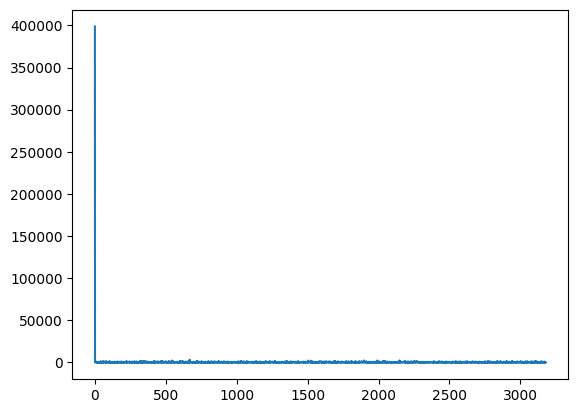

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(loss)), loss)

In [10]:
torch.save(model.state_dict(), "codec_dim_1024.pt")

In [11]:
model.load_state_dict(torch.load('codec_dim_1024.pt'))

<All keys matched successfully>

In [22]:
buow_ads['test'].set_transform(encode)
test_loader = DataLoader(buow_ads['test'], batch_size=8, num_workers=12, shuffle=True, pin_memory=True, pin_memory_device=config['device'])


test_losses = []


for data in tqdm(test_loader):
    x = data['audio']
    with torch.no_grad():
        label = x.to(config["device"], torch.float)
        
        x = encoder(label)
        
        pred = decoder(x)

    
        test_losses.append(score.item())
        break

  0%|          | 0/631 [00:00<?, ?it/s]

In [23]:
np.mean(test_losses)

np.float64(0.16119225323200226)

In [26]:
from IPython.display import Audio

Audio(data=label[6].detach().cpu(), rate=16000)

In [27]:
Audio(data=pred[6].detach().cpu(), rate=16000)